In [ ]:
#|default_exp pipeline

In [ ]:
#|export
from fastcore.imports import *
from fastcore.foundation import *
from fastcore.utils import *

from fasttransform.utils import is_tuple
from fasttransform.transform import Transform

In [ ]:
from __future__ import annotations
from nbdev.showdoc import *
from fastcore.test import *
from fastcore.nb_imports import *

# Pipeline

> A class for composing multiple (partially) reversible transforms

`Pipeline` allows you to compose multiple transforms that can be partially reversed through decoding. When a transform is "decoded", it creates a form suitable for display, though this may not be identical to the original input (for instance, a transform from bytes to floats would typically decode to floats rather than converting back to bytes, since that could lose precision).

`Pipeline` handles the composition of multiple transforms while maintaining the ability to decode or display the transformed items at any stage.

In [ ]:
#|export
def compose_tfms(x, tfms, is_enc=True, reverse=False, **kwargs):
    "Apply all `func_nm` attribute of `tfms` on `x`, maybe in `reverse` order"
    if reverse: tfms = reversed(tfms)
    for f in tfms:
        if not is_enc: f = f.decode
        x = f(x, **kwargs)
    return x
     

In [ ]:
def to_int  (x):   return Int(x)
def to_float(x):   return Float(x)
def double  (x):   return x*2
def half(x)->None: return x/2

In [ ]:
def test_compose(a, b, *fs): test_eq_type(compose_tfms(a, tfms=map(Transform,fs)), b)

test_compose(1,   Int(1),   to_int)
test_compose(1,   Float(1), to_int,to_float)
test_compose(1,   Float(2), to_int,to_float,double)
test_compose(2.0, 2.0,      to_int,double,half)

In [ ]:
class A(Transform):
    def encodes(self, x:float):  return Float(x+1)
    def decodes(self, x): return x-1
    
tfms = [A(), Transform(math.sqrt)]
t = compose_tfms(3., tfms=tfms)
test_eq_type(t, Float(2.))
test_eq(compose_tfms(t, tfms=tfms, is_enc=False), 1.)
test_eq(compose_tfms(4., tfms=tfms, reverse=True), 3.)
     

In [ ]:
tfms = [A(), Transform(math.sqrt)]
test_eq(compose_tfms((9,3.), tfms=tfms), (3,2.))

In [ ]:
#|export
def mk_transform(f):
    "Convert function `f` to `Transform` if it isn't already one"
    f = instantiate(f)
    return f if isinstance(f,(Transform,Pipeline)) else Transform(f)

In [ ]:
#|export
def gather_attrs(o, k, nm):
    "Used in __getattr__ to collect all attrs `k` from `self.{nm}`"
    if k.startswith('_') or k==nm: raise AttributeError(k)
    att = getattr(o,nm)
    res = [t for t in att.attrgot(k) if t is not None]
    if not res: raise AttributeError(k)
    return res[0] if len(res)==1 else L(res)

In [ ]:
#|export
def gather_attr_names(o, nm):
    "Used in __dir__ to collect all attrs `k` from `self.{nm}`"
    return L(getattr(o,nm)).map(dir).concat().unique()

In [ ]:
#|export
class Pipeline:
    "A pipeline of composed (for encode/decode) transforms, setup with types"
    def __init__(self, funcs=None, split_idx=None):
        self.split_idx,self.default = split_idx,None
        if funcs is None: funcs = []
        if isinstance(funcs, Pipeline): self.fs = funcs.fs
        else:
            if isinstance(funcs, Transform): funcs = [funcs]
            self.fs = L(ifnone(funcs,[noop])).map(mk_transform).sorted(key='order')
        for f in self.fs:
            name = camel2snake(type(f).__name__)
            a = getattr(self,name,None)
            if a is not None: f = L(a)+f
            setattr(self, name, f)

    def setup(self, items=None, train_setup=False):
        tfms = self.fs[:]
        self.fs.clear()
        for t in tfms: self.add(t,items, train_setup)

    def add(self,ts, items=None, train_setup=False):
        if not is_listy(ts): ts=[ts]
        for t in ts: t.setup(items, train_setup)
        self.fs+=ts
        self.fs = self.fs.sorted(key='order')

    def __call__(self, o): return compose_tfms(o, tfms=self.fs, split_idx=self.split_idx)
    def __repr__(self): return f"Pipeline: {' -> '.join([f.name for f in self.fs if f.name != 'noop'])}"
    def __getitem__(self,i): return self.fs[i]
    def __setstate__(self,data): self.__dict__.update(data)
    def __getattr__(self,k): return gather_attrs(self, k, 'fs')
    def __dir__(self): return super().__dir__() + gather_attr_names(self, 'fs')

    def decode  (self, o, full=True):
        if full: return compose_tfms(o, tfms=self.fs, is_enc=False, reverse=True, split_idx=self.split_idx)
        #Not full means we decode up to the point the item knows how to show itself.
        for f in reversed(self.fs):
            if self._is_showable(o): return o
            o = f.decode(o, split_idx=self.split_idx)
        return o

    def show(self, o, ctx=None, **kwargs):
        o = self.decode(o, full=False)
        o1 = (o,) if not is_tuple(o) else o
        if hasattr(o, 'show'): ctx = o.show(ctx=ctx, **kwargs)
        else:
            for o_ in o1:
                if hasattr(o_, 'show'): ctx = o_.show(ctx=ctx, **kwargs)
        return ctx

    def _is_showable(self, o):
        if hasattr(o, 'show'): return True
        if is_tuple(o): return all(hasattr(o_, 'show') for o_ in o)
        return False

In [ ]:
add_docs(Pipeline,
         __call__="Compose `__call__` of all `fs` on `o`",
         decode="Compose `decode` of all `fs` on `o`",
         show="Show `o`, a single item from a tuple, decoding as needed",
         add="Add transforms `ts`",
         setup="Call each tfm's `setup` in order")

In [ ]:
# Empty pipeline is noop
pipe = Pipeline()
test_eq(pipe(1), 1)
test_eq(pipe((1,)), (1,))
# Check pickle works
assert pickle.loads(pickle.dumps(pipe))

In [ ]:
class IntFloatTfm(Transform):
    def encodes(self, x):  return Int(x)
    def decodes(self, x):  return Float(x)
    foo=1

int_tfm=IntFloatTfm()

def neg(x): return -x
neg_tfm = Transform(neg, neg)

In [ ]:
pipe = Pipeline([neg_tfm, int_tfm])

start = 2.0
t = pipe(start)
test_eq_type(t, Int(-2))
test_eq_type(pipe.decode(t), Float(start))
test_stdout(lambda:pipe.show(t), '-2')

In [ ]:
pipe = Pipeline([neg_tfm, int_tfm])
t = pipe(start)
test_stdout(lambda:pipe.show(pipe((1.,2.))), '-1\n-2')
test_eq(pipe.foo, 1)
assert 'foo' in dir(pipe)
assert 'int_float_tfm' in dir(pipe)

You can add a single transform or multiple transforms ts using Pipeline.add. Transforms will be ordered by Transform.order.



In [ ]:
pipe = Pipeline([neg_tfm, int_tfm])
class SqrtTfm(Transform):
    order=-1
    def encodes(self, x): 
        return x**(.5)
    def decodes(self, x): return x**2
pipe.add(SqrtTfm())
test_eq(pipe(4),-2)
test_eq(pipe.decode(-2),4)
pipe.add([SqrtTfm(),SqrtTfm()])
test_eq(pipe(256),-2)
test_eq(pipe.decode(-2),256)

Transforms are available as attributes named with the snake_case version of the names of their types. Attributes in transforms can be directly accessed as attributes of the pipeline.

In [ ]:
test_eq(pipe.int_float_tfm, int_tfm)
test_eq(pipe.foo, 1)

pipe = Pipeline([int_tfm, int_tfm])
pipe.int_float_tfm
test_eq(pipe.int_float_tfm[0], int_tfm)
test_eq(pipe.foo, [1,1])

In [ ]:
# Check opposite order
pipe = Pipeline([int_tfm,neg_tfm])
t = pipe(start)
test_eq(t, -2)
test_stdout(lambda:pipe.show(t), '-2')

In [ ]:
class A(Transform):
    def encodes(self, x):  return int(x)
    def decodes(self, x):  return Float(x)

pipe = Pipeline([neg_tfm, A])
t = pipe(start)
test_eq_type(t, -2)
test_eq_type(pipe.decode(t), Float(start))
test_stdout(lambda:pipe.show(t), '-2.0')

In [ ]:
s2 = (1,2)
pipe = Pipeline([neg_tfm, A])
t = pipe(s2)
test_eq_type(t, (-1,-2))
test_eq_type(pipe.decode(t), (Float(1.),Float(2.)))
test_stdout(lambda:pipe.show(t), '-1.0\n-2.0')

In [ ]:
from PIL import Image


In [ ]:
class ArrayImage(ndarray):
    _show_args = {'cmap':'viridis'}
    def __new__(cls, x, *args, **kwargs):
        if isinstance(x,tuple): super().__new__(cls, x, *args, **kwargs)
        if args or kwargs: raise RuntimeError('Unknown array init args')
        if not isinstance(x,ndarray): x = array(x)
        return x.view(cls)
    
    def show(self, ctx=None, figsize=None, **kwargs):
        if ctx is None: _,ctx = plt.subplots(figsize=figsize)
        ctx.imshow(im, **{**self._show_args, **kwargs})
        ctx.axis('off')
        return ctx
    
im = Image.open(TEST_IMAGE)
im_t = ArrayImage(im)

In [ ]:
def f1(x:ArrayImage): return -x
def f2(x): return Image.open(x).resize((128,128))
def f3(x:Image.Image): return(ArrayImage(array(x)))
 

In [ ]:
pipe = Pipeline([f2,f3,f1])
t = pipe(TEST_IMAGE)
test_eq(type(t), ArrayImage)
test_eq(t, -array(f3(f2(TEST_IMAGE))))

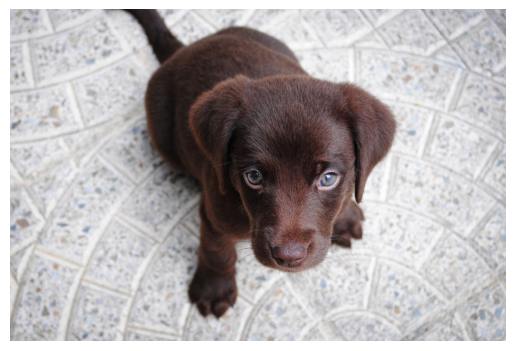

In [ ]:
pipe = Pipeline([f2,f3])
t = pipe(TEST_IMAGE)
ax = pipe.show(t)

In [ ]:
class A(Transform):
    def encodes(self, x):  return int(x)
    def decodes(self, x):  return Float(x)
    
class B(Transform):
    def encodes(self, x:int): return x+1
    def encodes(self, x:str): return x+'_hello'
    def decodes(self, x:int): return x-1
    def decodes(self, x:str): return x.replace('_hello', '')

In [ ]:
#Check filtering is properly applied
add1 = B()
add1.split_idx = 1
pipe = Pipeline([neg_tfm, A(), add1])
test_eq(pipe(start), -2)
pipe.split_idx=1
test_eq(pipe(start), -1)
pipe.split_idx=0
test_eq(pipe(start), -2)
for t in [None, 0, 1]:
    pipe.split_idx=t
    test_eq(pipe.decode(pipe(start)), start)
    test_stdout(lambda: pipe.show(pipe(start)), "-2.0")
   

In [ ]:
def neg(x): return -x
test_eq(type(mk_transform(neg)), Transform)
test_eq(type(mk_transform(math.sqrt)), Transform)
test_eq(type(mk_transform(lambda a:a*2)), Transform)
test_eq(type(mk_transform(Pipeline([neg]))), Pipeline)
  

## Export -

In [ ]:
#|hide
#|eval: false
from nbdev import nbdev_export
nbdev_export()